In [1]:
# import sys
# sys.path.append('../')

import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from distances import MahalanobisDistances, LogisticRegSensitiveSubspace, CausalDistance, ProtectedSEDistances, BinaryDistance, NormalizedSquaredEuclideanDistance
from utils import load_model
from dnn_models.model import MLP
from train_dnn import get_data
from data import adult
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
rand_seed = 0
use_protected_attr = True

dataset, train_dl, test_dl = get_data(adult, rand_seed)
dataset.use_protected_attr = use_protected_attr
in_dim = dataset.dim_feature()
out_dim = 2

model = MLP(in_dim, out_dim)
load_model(model, 'MLP', 'adult', 'STDTrainer', use_protected_attr=use_protected_attr, id=rand_seed)

In [3]:
in_dim

41

In [4]:
all_X, all_y = dataset.data, dataset.labels
# all_pred = model(all_X)
all_pred = model.get_prediction(all_X)
print(all_pred.shape)

train_X, train_y = [], []
for x, y in train_dl:
    train_X.append(x)
    train_y.append(y)
train_X = torch.concat(train_X, dim=0)
train_y = torch.concat(train_y, dim=0)

torch.Size([45222])


In [5]:
torch.cov(all_X.T).shape

torch.Size([41, 41])

In [6]:
xs = all_X[:10]
adult.get_original_feature(xs)

,age,capital-gain,capital-loss,education-num,hours-per-week,race_White,sex_Male,marital-status,occupation,relationship,workclass
0,39.0,2174.0,0.0,13.0,40.0,1.0,1.0,4.0,0.0,1.0,5.0
1,50.0,0.0,0.0,13.0,13.0,1.0,1.0,2.0,3.0,0.0,4.0
2,38.0,0.0,0.0,9.0,40.0,1.0,1.0,0.0,5.0,1.0,2.0
3,53.0,0.0,0.0,7.0,40.0,0.0,1.0,2.0,5.0,0.0,2.0
4,28.0,0.0,0.0,13.0,40.0,0.0,0.0,2.0,9.0,5.0,2.0
5,37.0,0.0,0.0,14.0,40.0,1.0,0.0,2.0,3.0,5.0,2.0
6,49.0,0.0,0.0,5.0,16.0,0.0,0.0,3.0,7.0,1.0,2.0
7,52.0,0.0,0.0,9.0,45.0,1.0,1.0,2.0,3.0,0.0,4.0
8,31.0,14084.0,0.0,14.0,50.0,1.0,0.0,4.0,9.0,1.0,2.0
9,42.0,5178.0,0.0,13.0,40.0,1.0,1.0,2.0,3.0,0.0,2.0


In [7]:
len(all_X)

45222

In [8]:
adult_gen = adult.Adult_gen(include_protected_feature=use_protected_attr)
distance_x_Ma = MahalanobisDistances()
distance_x_LR = LogisticRegSensitiveSubspace()
distance_x_NSE = NormalizedSquaredEuclideanDistance()
if use_protected_attr:
    distance_x_Ca = CausalDistance()
    distance_x_PSE = ProtectedSEDistances()

distance_y = BinaryDistance()

distance_x_Ma.fit(sigma=torch.cov(train_X.T))
distance_x_LR.fit(train_X, protected_idxs=dataset.protected_idxs, keep_protected_idxs=use_protected_attr)
if use_protected_attr:
    distance_x_Ca.fit(protected_idx=dataset.protected_idxs, num_dims=in_dim)
    distance_x_PSE.fit(protected_idx=dataset.protected_idxs, num_dims=in_dim)
distance_x_NSE.fit(num_dims=dataset.dim_feature(), data_gen=adult_gen)

In [9]:
def get_L_batch(samples, dx, dy):
    data_x, data_y = all_X, all_pred
    dxs = dx(samples[0], data_x, itemwise_dist=False)
    dys = dy(samples[1], data_y, itemwise_dist=False)

    L = (dys/dxs).squeeze()
    top, _ = torch.topk(L.view(-1), 50000)
    return L, top

def get_L_threshold(dataset, dx, dy):
    dl = DataLoader(dataset, batch_size=500, shuffle=False)
    L = []
    top = torch.Tensor()
    for b in tqdm(dl):
        L_batch, top_batch = get_L_batch(b, dx, dy)
        L.append(L_batch)
        top = torch.concat([top, top_batch], dim=0)
        top, _ = torch.topk(top.view(-1), 50000)
    L = torch.concat(L, dim=0)
    torch.save(L, 'tmp/L.pth')

    # th = torch.quantile(L, 1 - overall_unfair_ratio)
    th = top.min()
    has_unfair = torch.sum(L >= th, dim=1)
    return th, has_unfair


In [10]:
from torch.utils.data import TensorDataset
ds = TensorDataset(all_X, all_pred)
th, has_unfair = get_L_threshold(ds, distance_x_NSE, distance_y)
print('complete calculate L')
has_unfair = has_unfair.numpy()

100%|██████████| 91/91 [07:25<00:00,  4.90s/it]


complete calculate L


In [11]:
L = torch.load('tmp/L.pth')
n_unfair = torch.sum(L>4.5).item()

total_pairs = all_X.shape[0]**2

unfair_ratio = n_unfair/total_pairs

unfair_idxs = torch.where(L>4.5)
p = all_X[[unfair_idxs[0][0], unfair_idxs[1][0]], :]
p

tensor([[28.,  0.,  0., 13., 40.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [28.,  0.,  0., 13., 40.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [19]:
L[unfair_idxs[0][0], unfair_idxs[1][0]]

tensor(8.4026)

In [13]:
L.shape

torch.Size([45222, 45222])

In [12]:
y_p = model.get_prediction(p)
print(y_p)

tensor([1, 1])


In [21]:
distance_y(y_p[0].unsqueeze(0), y_p[1].unsqueeze(0), itemwise_dist=False)/distance_x_Ma(p[0].unsqueeze(0), p[1].unsqueeze(0), itemwise_dist=False)

tensor([[[0.]]])

In [11]:
print(th)

tensor(4.1641)


In [12]:
has_unfair.max()

69

In [13]:
len(has_unfair)

45222

In [14]:
len(has_unfair[has_unfair!=0])

8570

0.9857142857142858


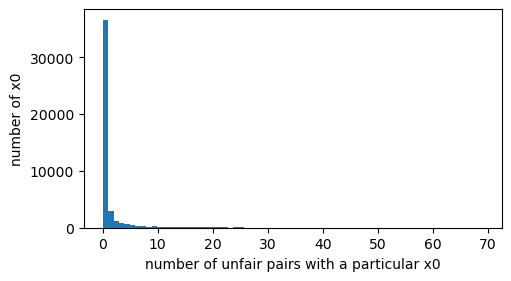

In [15]:
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
n, bins, patches = ax.hist(has_unfair, bins=int((max(has_unfair) - min(has_unfair) + 1)))
ax.set_xlabel('number of unfair pairs with a particular x0')
ax.set_ylabel('number of x0')
print(bins[1])

In [16]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(all_X)


/data/liuyuanhao/anaconda3/envs/torch1.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/data/liuyuanhao/anaconda3/envs/torch1.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


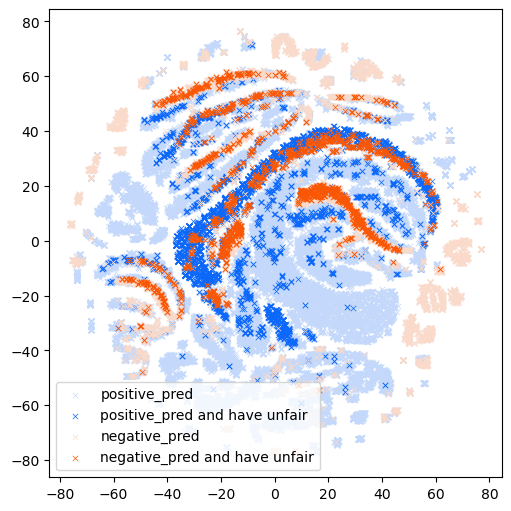

In [17]:
import numpy as np

fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
mask = np.logical_and(all_pred.numpy() == 0, has_unfair == 0)
ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=15, color='#c3d8fa', marker='x', label='positive_pred', linewidths=0.5)
mask = np.logical_and(all_pred.numpy() == 0, has_unfair != 0).astype(bool)
ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=15, color='#0c68fa', marker='x', label='positive_pred and have unfair', linewidths=0.5)
mask = np.logical_and(all_pred.numpy() != 0, has_unfair == 0).astype(bool)
ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=15, color='#fadaca', marker='x', label='negative_pred', linewidths=0.5)
mask = np.logical_and(all_pred.numpy() != 0, has_unfair != 0).astype(bool)
ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=15, color='#fa5705', marker='x', label='negative_pred and have unfair', linewidths=0.5)
ax.legend()

In [1]:
from torch.utils.data import TensorDataset
def batch_load_L(batch_size=500):
    L = torch.load('tmp/L.pth')
    ds = TensorDataset(L)
    dl = DataLoader(ds, batch_size=batch_size)
    for batch in dl:
        yield batch

def n_unfair_per_sample_by_th(L_loader, th):
    n_unfair = []
    for batch in tqdm(L_loader):
        batch_n = torch.sum(batch[0]>th, dim=1)
        n_unfair.append(batch_n)
    n_unfair = torch.concat(n_unfair, dim=0).numpy()
    return n_unfair

def th_per_sample_by_ratio(L_loader, ratio):
    th = []
    for batch in tqdm(L_loader):
        batch_th = torch.quantile(batch[0], q=1-ratio, dim=1)
        th.append(batch_th)
    th = torch.concat(th, dim=0).numpy()
    return th

In [2]:
def hist(data, title=None, x_lab=None, y_lab=None, multiple=1):
    fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
    n, bins, patches = ax.hist(data, bins=int((max(data) - min(data) + 1))*multiple)
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.set_title(title)
    print(f'bin width: {bins[1] - bins[0]}')

91it [00:32,  2.76it/s]


bin width: 0.9948453608247423


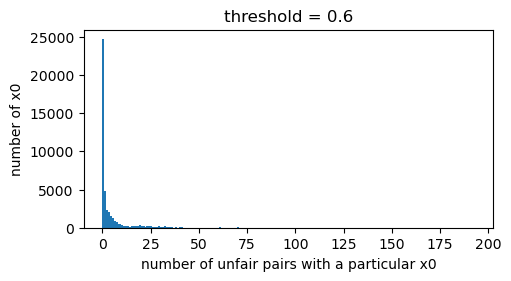

In [5]:
eps = 0.6
n_unfair = n_unfair_per_sample_by_th(batch_load_L(), th=eps)
hist(n_unfair, 
     x_lab='number of unfair pairs with a particular x0',
     y_lab='number of x0',
     title=f'threshold = {eps}')

91it [00:27,  3.30it/s]


bin width: 0.0003212550363969037


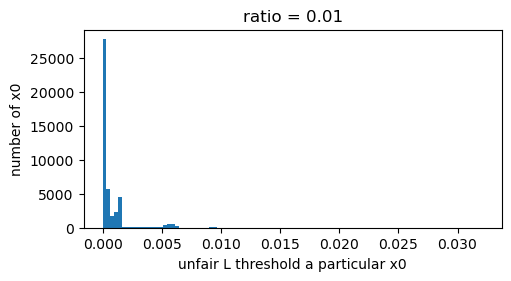

In [6]:
r = 0.01
ths = th_per_sample_by_ratio(batch_load_L(), ratio=r)
hist(ths, 
     x_lab='unfair L threshold a particular x0',
     y_lab='number of x0',
     title=f'ratio = {r}',
     multiple=100)

In [22]:
def unfair_pairs_by_th(L_loader, th_range):
    unfair_pairs = []
    start_id = 0
    for batch in tqdm(L_loader):
        batch = batch[0]
        idx, idy = torch.where(torch.logical_and(batch>th_range[0], batch<th_range[1]))
        idx += start_id

        unfair_pairs.extend(list(zip(idx.tolist(), idy.tolist())))
        start_id += batch.shape[0]

    return unfair_pairs

In [23]:
th_range = [0.05, 0.5]
unfair_pairs = unfair_pairs_by_th(batch_load_L(), th_range)
len(unfair_pairs)

91it [00:13,  6.92it/s]


697286

In [24]:
adult.get_original_feature(all_X[list(unfair_pairs[0])])

,age,capital-gain,capital-loss,education-num,hours-per-week,race_White,sex_Male,marital-status,occupation,relationship,workclass
0,38.0,0.0,0.0,9.0,40.0,1.0,1.0,0.0,5.0,1.0,2.0
1,38.0,0.0,0.0,9.0,40.0,1.0,1.0,2.0,0.0,0.0,0.0


In [25]:
th_range = [0.5, 5]
unfair_pairs = unfair_pairs_by_th(batch_load_L(), th_range)
len(unfair_pairs)

91it [00:13,  6.87it/s]


194364

In [26]:
adult.get_original_feature(all_X[list(unfair_pairs[10])])

,age,capital-gain,capital-loss,education-num,hours-per-week,race_White,sex_Male,marital-status,occupation,relationship,workclass
0,28.0,0.0,0.0,13.0,40.0,0.0,0.0,2.0,9.0,5.0,2.0
1,28.0,0.0,0.0,13.0,40.0,1.0,0.0,2.0,3.0,5.0,2.0


In [27]:
import random
def rand_gen():
    return {
        'age': random.randint(15, 60),
        'capital_gain': 0,
        'capital_loss': 0,
        'education_num': random.randint(1, 15),
        'hours_per_week': random.randint(10, 50),
        'race_white': random.choice([0, 1]),
        'sex_male': random.choice([0, 1]),
        'marital_status': random.choice(list(range(7))),
        'occupation': random.choice(list(range(14))),
        'relationship': random.choice(list(range(6))),
        'workclass': random.choice(list(range(7)))
    }

def perturb_pair(x, pert, value):
    pair = dict()
    for k, v in x.items():
        pair[k] = torch.tensor([v, v])
        if k == pert:
            pair[k][1] = value
    return pair
    

In [41]:
x = rand_gen()
x

{'age': 58,
 'capital_gain': 0,
 'capital_loss': 0,
 'education_num': 7,
 'hours_per_week': 33,
 'race_white': 1,
 'sex_male': 1,
 'marital_status': 2,
 'occupation': 8,
 'relationship': 1,
 'workclass': 4}

In [42]:
pair = adult.generate_from_origin(**perturb_pair(x, 'sex_male', 1-x['sex_male']))
1 / distance_x_Ma(pair[0], pair[1])

tensor([[4.5636]])

In [43]:
model.get_prediction(pair)

tensor([0, 0])